<a href="https://colab.research.google.com/github/takakurahashi/github.io/blob/master/kinyuu_kurasuta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# データ加工・処理・分析ライブラリ
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機械学習ライブラリ
import sklearn
# k-means法を使うためのインポート
from sklearn.cluster import KMeans

# 小数第3位まで表示
%precision 3

'%.3f'

In [2]:
# webからデータを取得したり、zipファイルを扱うためのライブラリをインポート
import requests, zipfile
import io

# データがあるurl の指定
zip_file_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'

# データを取得して展開する
r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [3]:
#対象データを読み込み
bank= pd.read_csv('bank-full.csv', sep=';')

# 先頭の5行を表示
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
print('データ形式(X,y):{}'.format(bank.shape))
print('欠損データの数:{}'.format(bank.isnull().sum().sum()))
# データの整理と標準化

データ形式(X,y):(45211, 17)
欠損データの数:0


In [5]:
from sklearn.preprocessing import StandardScaler

# データの列の絞り込み
bank_sub = bank[['age','balance','campaign','previous']]

# 標準化
sc = StandardScaler()
sc.fit(bank_sub)
bank_sub_std = sc.transform(bank_sub)

In [6]:
bank_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       45211 non-null  int64
 1   balance   45211 non-null  int64
 2   campaign  45211 non-null  int64
 3   previous  45211 non-null  int64
dtypes: int64(4)
memory usage: 1.4 MB


0    14411
1    23608
2     3837
3     1373
4     1282
5      700
Name: cluster_number, dtype: int64


Text(0, 0.5, 'count')

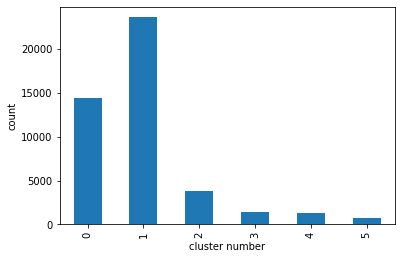

In [7]:
# クラスタリングの処理
# KMeansクラスの初期化
kmeans = KMeans(init='random', n_clusters=6, random_state=0)

# クラスターの重心を計算
kmeans.fit(bank_sub_std)

# クラスター番号をpandasのSeriesオブジェクトに変換
labels = pd.Series(kmeans.labels_, name='cluster_number')

# クラスター番号と件数を表示
print(labels.value_counts(sort=False))

# グラフを描画
ax = labels.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel('cluster number')
ax.set_ylabel('count')

In [8]:
# データ取得のためのインポート
from sklearn.datasets import make_blobs

# サンプルデータ生成
# 注意：make_blobsは2つの値を返すため、一方は使用しない「 _ 」で受け取る
X, _ = make_blobs(random_state=10)

Text(0, 0.5, 'Distortion')

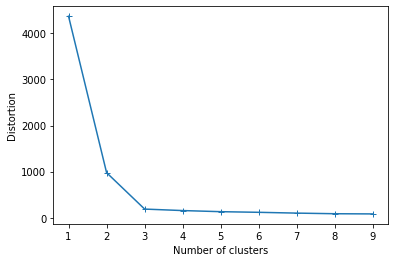

In [9]:
# エルボー方による推定。クラスター数を1から10に増やして、それぞれの距離の総和を求める
dist_list =[]
for i in range(1,10):
    kmeans= KMeans(n_clusters=i, init='random', random_state=0)
    kmeans.fit(X)
    dist_list.append(kmeans.inertia_)
    
# グラフを表示
plt.plot(range(1,10), dist_list,marker='+')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

Text(0, 0.5, 'Distortion')

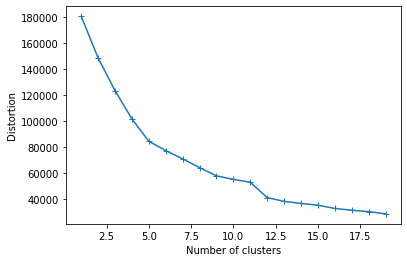

In [10]:
# クラスタリング結果の解釈
# エルボー方による推定。クラスター数を1から20に増やして、それぞれの距離の総和を求める
dist_list =[]
for i in range(1,20):
    kmeans= KMeans(n_clusters=i, init='random', random_state=0)
    kmeans.fit(bank_sub_std)
    dist_list.append(kmeans.inertia_)
    
# グラフを表示
plt.plot(range(1,20), dist_list,marker='+')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

In [11]:
# 金融機関のデータにクラスター番号のデータを結合
bank_with_cluster = pd.concat([bank, labels], axis=1)

# 先頭の5行を表示
bank_with_cluster.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,cluster_number
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,1


In [12]:
# 分割のための区切りを設定
bins = [15,20,25,30,35,40,45,50,55,60,65,100]

# 上の区切りをもとに金融機関のデータを分割し、qcut_age変数に各データの年齢層を設定
qcut_age = pd.cut(bank_with_cluster.age, bins, right=False)
print(qcut_age)

# クラスタ番号と年齢層を結合
df = pd.concat([bank_with_cluster.cluster_number, qcut_age], axis=1)

# クラスタ番号と年齢層を軸に集計し、年齢層を列に設定
cross_cluster_age = df.groupby(['cluster_number', 'age']).size().unstack().fillna(0)
cross_cluster_age

0         [55, 60)
1         [40, 45)
2         [30, 35)
3         [45, 50)
4         [30, 35)
           ...    
45206     [50, 55)
45207    [65, 100)
45208    [65, 100)
45209     [55, 60)
45210     [35, 40)
Name: age, Length: 45211, dtype: category
Categories (11, interval[int64]): [[15, 20) < [20, 25) < [25, 30) < [30, 35) ... [50, 55) < [55, 60) <
                                   [60, 65) < [65, 100)]


age,"[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 100)"
cluster_number,,,,,,,,,,,
0,0,0,0,0,0,1023,4490,3833,3480,850,735
1,45,705,3965,8221,6731,3941,0,0,0,0,0
2,1,20,230,788,956,718,598,328,165,29,4
3,0,20,129,327,306,186,145,117,71,38,34
4,0,11,74,240,219,203,156,140,155,48,36
5,1,6,66,164,137,114,81,70,51,9,1


In [13]:
# 分割したデータ数をカウント
hist_age = pd.value_counts(qcut_age)
hist_age

[30, 35)     9740
[35, 40)     8349
[40, 45)     6185
[45, 50)     5470
[50, 55)     4488
[25, 30)     4464
[55, 60)     3922
[60, 65)      974
[65, 100)     810
[20, 25)      762
[15, 20)       47
Name: age, dtype: int64

In [14]:
cross_cluster_age.apply(lambda x : x/x.sum())

age,"[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 100)"
cluster_number,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.165400,0.820841,0.854055,0.887302,0.872690,0.907407
1,0.957447,0.925197,0.888217,0.844045,0.806204,0.637187,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.021277,0.026247,0.051523,0.080903,0.114505,0.116087,0.109324,0.073084,0.042070,0.029774,0.004938
3,0.000000,0.026247,0.028898,0.033573,0.036651,0.030073,0.026508,0.026070,0.018103,0.039014,0.041975
4,0.000000,0.014436,0.016577,0.024641,0.026231,0.032821,0.028519,0.031194,0.039521,0.049281,0.044444
5,0.021277,0.007874,0.014785,0.016838,0.016409,0.018432,0.014808,0.015597,0.013004,0.009240,0.001235


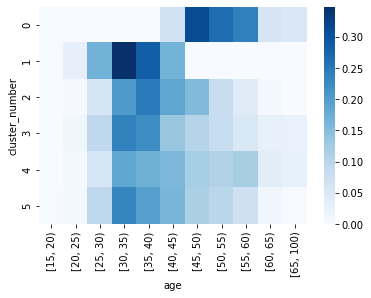

In [15]:
# ヒートマップ
sns.heatmap(cross_cluster_age.apply(lambda x : x/x.sum(), axis=1), cmap='Blues')

In [16]:
cross_cluster_job = bank_with_cluster.groupby(['cluster_number', 'job']).size().unstack().fillna(0)
cross_cluster_job

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
cluster_number,,,,,,,,,,,,
0,1408,2906,530,652,2723,2006,476,1073,3,2048,432,154
1,3005,5385,697,409,4933,55,820,2474,812,4256,687,75
2,392,862,145,107,895,59,139,370,42,701,91,34
3,193,239,42,21,335,53,42,113,53,244,33,5
4,109,175,54,36,417,77,71,69,22,192,49,11
5,64,165,19,15,155,14,31,55,6,156,11,9


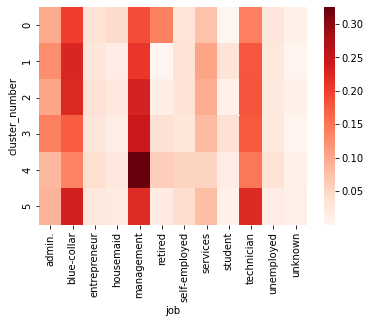

In [17]:
sns.heatmap(cross_cluster_job.apply(lambda x : x/x.sum(), axis=1),cmap='Reds')